In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")

In [5]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [6]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))

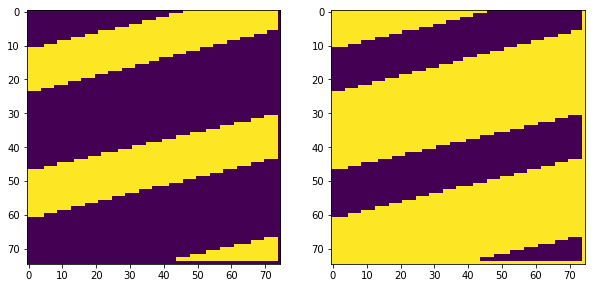

In [19]:
%matplotlib inline

def inverse_mask(mask):
    return ((mask == 0) * 255).astype(np.uint8)

_, ax = plt.subplots(1,2, figsize = (10,10))

mask = mask_images[0]
inv_mask = inverse_mask(mask)

ax[0].imshow(mask)
ax[1].imshow(inv_mask)

In [22]:
mask.dtype, inv_mask.dtype

(dtype('uint8'), dtype('uint8'))

In [23]:
inverse_masks = [inverse_mask(mask) for mask in mask_images]

In [36]:
def normalized_hist(hist_image, channel, mask=None):
    hist = cv.calcHist([hist_image], [channel], mask, [256], [0, 255])  
    number_of_pixels = hist_image.size if mask is None else mask[mask > 0].size
    return hist / number_of_pixels

def all_bands_hist(hist_image, mask=None):
    all_bands_hist = []
    for i in range(3):
        all_bands_hist.extend(normalized_hist(hist_image, i, mask))
    return np.array(all_bands_hist)

def plot_hist(hist_image, mask=None):
    normalized_counts = []
    for i, col in enumerate(["b", "g", "r"]):
        normalized_counts.append(normalized_hist(hist_image, i, mask))
        plt.plot(normalized_counts,color = col)
        plt.xlim([0,255])
    return np.array(normalized_counts)

In [43]:
positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, mask_images)]).reshape(120, 768)
negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)]).reshape(120, 768)

In [44]:
positives.shape, negatives.shape

((120, 768), (120, 768))

In [54]:
positive_labels = np.ones(120)
negative_labels = np.zeros(120)

In [66]:
all_histograms = np.concatenate((positives, negatives))
all_labels = np.concatenate((positive_labels, negative_labels))
all_histograms.shape, all_labels.shape

((240, 768), (240,))

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_histograms, all_labels, test_size = 0.20)

In [62]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [64]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        29
         1.0       1.00      0.89      0.94        19

   micro avg       0.96      0.96      0.96        48
   macro avg       0.97      0.95      0.96        48
weighted avg       0.96      0.96      0.96        48

accuracy=0.9583333333333334
[[29  0]
 [ 2 17]]


In [65]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00222019,
       0.        , 0.        , 0.        , 0.        , 0.     

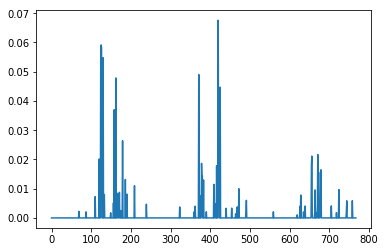

In [76]:
plt.plot(clf.feature_importances_)

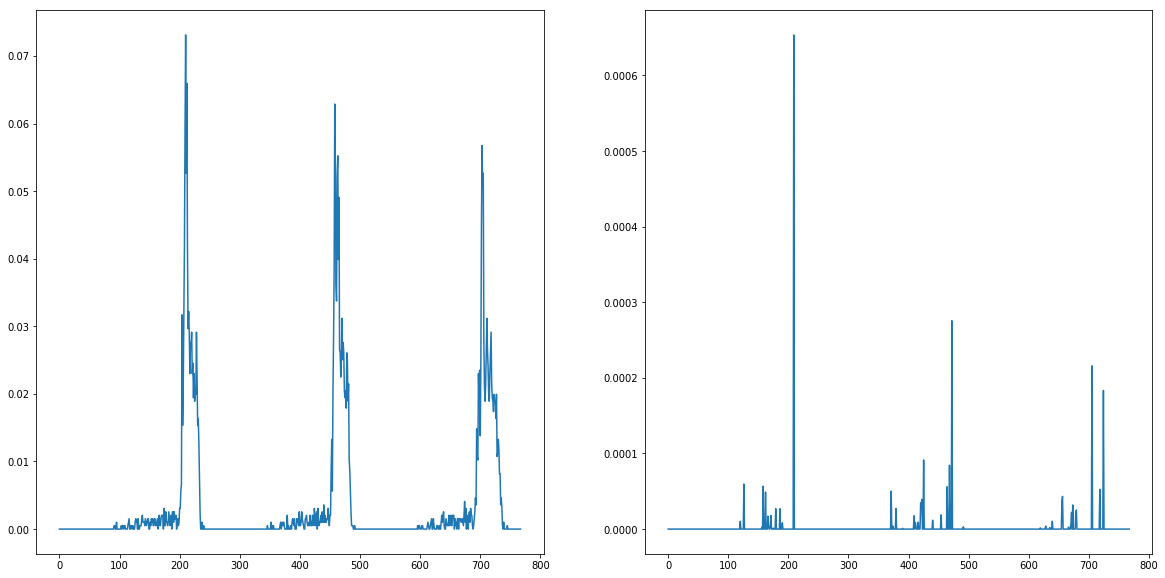

In [75]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[0])
ax[1].plot(all_histograms[0] * clf.feature_importances_)

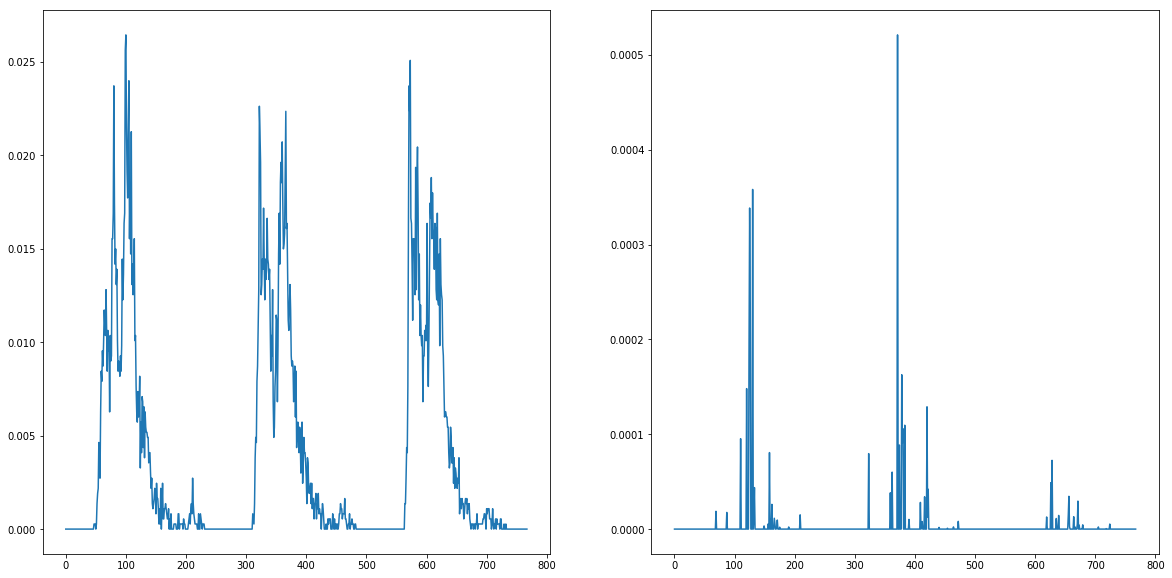

In [73]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[120])
ax[1].plot(all_histograms[120] * clf.feature_importances_)